### What is a parameter?

-  Components of the model learned during the modeling process
- You **do not** set these manually (you can't in fact!)
- The algorithm will discover these for you

#### Parameters in Random Forest

- Random forest has no coefficients, but node decisions (what feature and what value to split on)

~~~
rf_clf = RandomForestClassifier(max_depth=2)
rf_clf.fit(X_train, y_train)

chosen_tree = rf_clf.estimators_[7]
~~~

For simplicity we will show the final product (an image) of the decision tree. Feel free to explore the package used for this (graphviz & pydotplus) yourself.


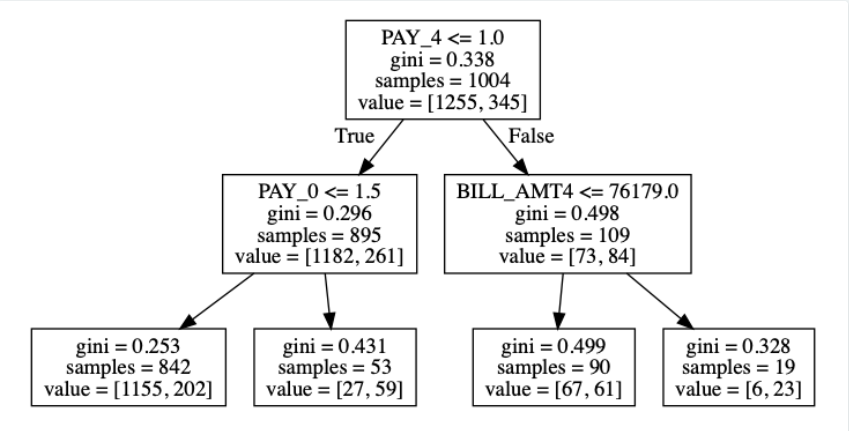

In [2]:
from IPython.display import Image
Image('decision-tree.PNG')

#### Extracting Node Decisions

We can pull out details of the left, second-from-top node:

~~~
split_column = chosen_tree.tree_.feature[1]
split_column_name = X_train.columns[split_column]

split_value = chosen_tree.tree_.threshold[1]

print('This node split on feature {}, at a value of {}'.format(split_column_name, split_value))
~~~


### What is a hyperparameter

- Something **you** set before the modeling process
- The algorithm does not learn these

#### Setting hyperparameters

~~~
rf_clf = RandomForestClassifier(n_estimators=100, criterion='entropy')

print(rf_clf)
~~~

#### Conflicting Hyperparameter Choices

Be aware of conflicting hyperparameter choices.

- *solver* and *penalty* of *LogisticRegression()*

~~~
The 'newton-cg', 'sag' and 'lbfgs' solvers only support 'l2' penalties.
~~~

- Some aren't explicit but will just ignore (*normalize* from *ElasticNet*)

~~~
This parameter is ignored when 'fit_intercept' is set to False.
~~~

#### Silly Hyperparameter Values

- Random forest with low number of trees
- One neighbor in KNN
- Increasing a hyperparameter by a very small amount



### Grid Search

#### Advantages

- You don't have to write thousands of lines of code
- Finds the best model **within the grid**

#### Disadvantages

- Computationally expensive
- It is uninformed

#### In scikit-learn

- Steps:
1. An algorithm to tune the hyperparameters
2. Defining which hyperparameters we will tune
3. Defining a range of values for each hyperparameter
4. Setting a cross-validation scheme, and
5. Define a score function so we can decide which square on our grid was the best
6. Include extra useful information or functions.

- Inputs:
	- estimator: essentially the algorithm
	- param_grid: which hyperparameters values to test. Receives a dict, whose keys are the hyperparameters' names.
	- cv: cross-validation K.
	- scoring: scoring function to evaluate the models' performance
		~~~
		from sklearn import metrics
		sorted(metrics.SCORERS.keys())
		~~~
	- refit: fits the best hyperparameters to the training data
	- n_jobs: allows multiple models to be created at the same time, rather than one after the other
	- return_train_score: logs statistics about the training runs that were undertaken. Does not assist in picking the best model, only for analysis purposes.

~~~
parameter_grid = {'max_depth': [2, 4, 6, 8],
		'min_samples_leaf': [1, 2, 4, 6]}

rf_class = RandomForestClassifier(criterion='entropy', max_features='auto')

grid_rf_class = GridSearchCV(estimator=rf_class,
			param_grid=parameter_grid,
			scoring='accuracy',
			n_jobs=4,
			cv=10,
			refit=True,
			return_train_score=True)

grid_rf_class.fit(X_train, y_train)

grid_rf_class.predict(X_test)
~~~

#### GridSearchCV.cv_results_

- test_score column: scores on our test for each of our cv-folds and summary sctatistics
- params_ column: the parameters tested on that row, one column per parameter
- params column: dictionaryies of all parameters
- rank_test_score: rank column of mean_test_score, from best to worst

- Extracting the best row

~~~
cv_results_df = pd.DataFrame(grid_rf_class.cv_results_)

best_row = cv_results_df[cv_results_df['rank_test_score']==1]

print(best_row)
~~~

- The best grid square
	- best_params_: dict of parameters that gave  the best score
	- best_score_: the actual best score
	- best_index: the row in cv_results_.rank_test_score that was the best
	- best_estimator_: estimator built using the best_params_


### Random Search

- Key differences from GridSearch
	- n_iter: the number of samples for the random search to take from your grid.
	- param_distributions: set distributions for sampling (default: uniform)

~~~
learn_rate_list = np.linspace(0.001, 2, 150)
min_samples_list = list(range(1, 51))

param_grid = {'learning_rate': learn_rate_list,
		'min_samples_leaf': min_samples_leaf_list}

number_models = 10

random_gbm = RandomizedSearchCV(estimator= GradientBoostingClassifier(),
			param_distributions= param_grid,
			n_iter = number_models,
			scoring = 'accuracy',
			n_jobs = 4,
			cv = 10,
			refit = True,
			return_train_score = True)

random_gbm.fit(X_train, y_train)
~~~

### Informed Search

#### Coarse to Fine Tuning

1. Random Search
2. Find promising areas
3. Grid search the smaller area
4. Continue until optimal score is obtained

#### Bayesian Statistics

- Bayes' Rule
	- A statistical method of using *new evidence* to iteratively update our beliefs about some outcome.

$P(A|B) = \displaystyle\frac{P(B|A)\ P(A)}{P(B)}$

- LHS: the probability of A, given that B (new evidence) has occured
	- Known as 'posterior'
- RHS: how we calculate this.
	- $P(A)$: is the 'prior' (initial hypothesis about the event).
	- $P(B)$: is the 'marginal likelihood' (the probability of observing this new evidence).
	- $P(B|A)$: is the 'likelihood' (the probability of observing the evidence, given the event we care about).

##### Example

- 5% of people in the general population have a certain disease: $P(D)$
- 10% of people are predisposed: $P(Pre)$
- 20% of people with the disease are predisposed: $P(Pre|D)$
- What is the probability that any person has the disease?
	- This is simply our prior as we have no evidence.
	- $P(D) = 0.05$
- What is the probability that a *predisposed* person has the disease?
	- Bayes' Rule: $P(D|Pre) = \displaystyle\frac{P(Pre|D)\ P(D)}{P(Pre)} = \displaystyle\frac{0.2 \cdot 0.05}{0.1} = 0.1$

#### In Hyperopt

1. Set the domain: our grid (with a bit of a twist);
2. Set the optimization algorithm (use deafult TPE);
3. Objective function to minimize: we will use 1 - Accuracy.

~~~
import hyperopt as hp

# Set up the grid
space = {
	'max_depth': hp.quinform('max_depth', 2, 10, 2),
	'min_samples_leaf': hp.quinform('min_samples_leaf', 2, 8, 2),
	'learning_rate': hp.quniform('learning_rate', 0.01, 1, 55)
}

# Objective function
def objective(params):
	param = {'max_depth': int(params['max_depth']),
		'min_samples_leaf': int(params['min_samples_leaf']),
		'learning_rate': params['learning_rate']}

	gbm_clf = GradientBoostingClassifier(n_estimators=500, **param)

	best_score = cross_val_score(gbm_clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=4).mean()

	loss = 1 - best_score
	
	return loss

# Run the algorithm
best_results = hp.fmin(fn=objective, space=space,
			max_evals=500, rstate=np.random.RandomState(42), algo=hp.tpe.suggest)
~~~

#### Genetic Algorithms

1. There are many creatures existing ('offspring')
2. The strongest creatures survive and pair off
3. There is some 'crossover' as they form offspring
4. There are random mutations to some of the offspring
	- These mutations sometimes help give some offspring an advantage

##### TPOT

- Components:
	- generations: iterations to run training for.
	- population_size: the number of models to keep after each iteration
	- offspring_size: number of models to produce in each iteration
	- mutation_rate: the proportion of pipelines to apply randomness to
	- crossover_rate: the proportion of pipelines to breed each iteration

~~~
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=3, population_size=5,verbosity=2, offspring_size=10, scoring='accuracy', cv=5)

tpot.fit(X_train, y_train)
print(tpot.score(X_test,y_test))
~~~
